In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [2]:
#DATA SETUP & TRANSFORMS
dataset_root = r"C:\Users\yozev\OneDrive\Desktop\artFiltered"

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(root=dataset_root, transform=transform)
print("Classes:", full_dataset.classes)

Classes: ['Abstract_Expressionism', 'Art_Nouveau_Modern', 'Baroque', 'Cubism', 'Expressionism', 'Impressionism', 'Naive_Art_Primitivism', 'Northern_Renaissance', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism']


In [3]:
# SPLIT DATA INTO TRAIN/VAL/TEST
dataset_size = len(full_dataset)
train_size = int(0.75 * dataset_size)
val_size = int(0.10 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

print(f"Dataset sizes -> Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Dataset sizes -> Train: 48563, Val: 6475, Test: 9713


In [5]:
#DEFINE PRE-TRAINED MODEL (ResNet18)
from torchvision.models import ResNet18_Weights

num_classes = len(full_dataset.classes)
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

In [6]:
# TRAINING SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 25
for epoch in range(epochs):
    #TRAINING 
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    #VALIDATION
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}]  "
          f"Train Loss: {avg_train_loss:.4f},  "
          f"Val Loss: {avg_val_loss:.4f}")

Epoch [1/25]  Train Loss: 1.5555,  Val Loss: 1.2275
Epoch [2/25]  Train Loss: 1.1964,  Val Loss: 1.1295
Epoch [3/25]  Train Loss: 1.0417,  Val Loss: 1.0808
Epoch [4/25]  Train Loss: 0.9273,  Val Loss: 1.0244
Epoch [5/25]  Train Loss: 0.8320,  Val Loss: 1.0485
Epoch [6/25]  Train Loss: 0.6363,  Val Loss: 0.8976
Epoch [7/25]  Train Loss: 0.5732,  Val Loss: 0.8925
Epoch [8/25]  Train Loss: 0.5336,  Val Loss: 0.8828
Epoch [9/25]  Train Loss: 0.5057,  Val Loss: 0.9150
Epoch [10/25]  Train Loss: 0.4823,  Val Loss: 0.9243
Epoch [11/25]  Train Loss: 0.4490,  Val Loss: 0.9009
Epoch [12/25]  Train Loss: 0.4458,  Val Loss: 0.9152
Epoch [13/25]  Train Loss: 0.4399,  Val Loss: 0.9084
Epoch [14/25]  Train Loss: 0.4362,  Val Loss: 0.8959
Epoch [15/25]  Train Loss: 0.4327,  Val Loss: 0.9121
Epoch [16/25]  Train Loss: 0.4303,  Val Loss: 0.9046
Epoch [17/25]  Train Loss: 0.4322,  Val Loss: 0.9077
Epoch [18/25]  Train Loss: 0.4340,  Val Loss: 0.9173
Epoch [19/25]  Train Loss: 0.4314,  Val Loss: 0.9016
Ep

In [7]:
#EVALUATION ON TEST SET
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted')

print("=== TEST METRICS ===")
print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1 Score:   {f1:.4f}")


=== TEST METRICS ===
Accuracy:   0.7015
Precision:  0.7019
Recall:     0.7015
F1 Score:   0.7005


C:\Users\yozev\AppData\Local\Temp\ipykernel_38276\801274513.py:52: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


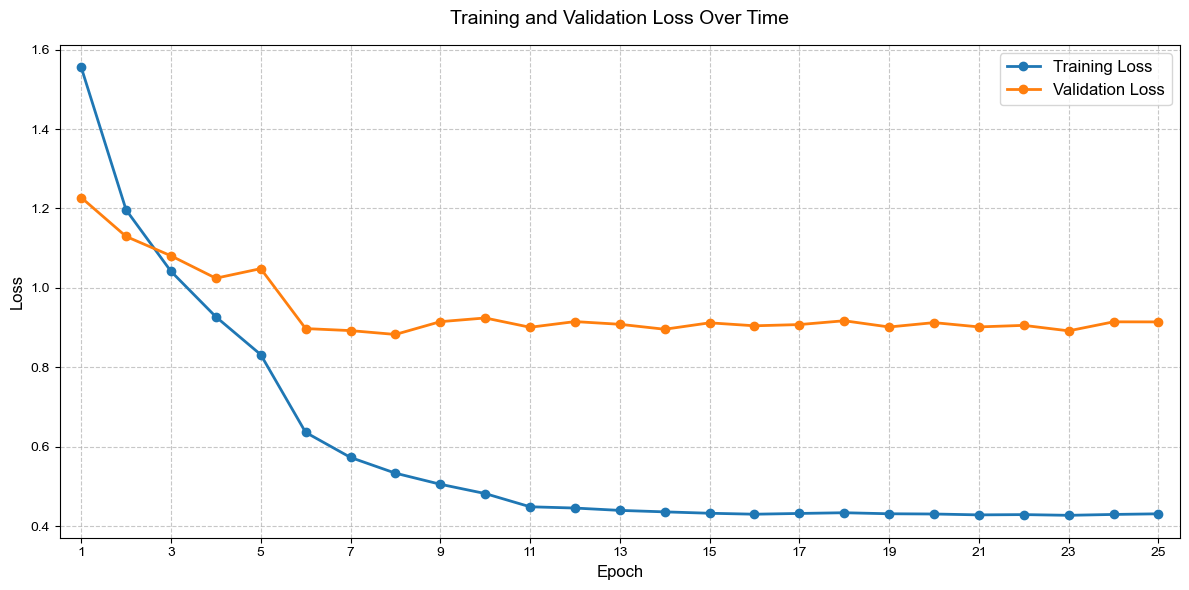

In [1]:
import matplotlib.pyplot as plt

# Store the training history from your output
training_history = [
    [1.5555, 1.2275],  # Epoch 1
    [1.1964, 1.1295],  # Epoch 2
    [1.0417, 1.0808],  # Epoch 3
    [0.9273, 1.0244],  # Epoch 4
    [0.8320, 1.0485],  # Epoch 5
    [0.6363, 0.8976],  # Epoch 6
    [0.5732, 0.8925],  # Epoch 7
    [0.5336, 0.8828],  # Epoch 8
    [0.5057, 0.9150],  # Epoch 9
    [0.4823, 0.9243],  # Epoch 10
    [0.4490, 0.9009],  # Epoch 11
    [0.4458, 0.9152],  # Epoch 12
    [0.4399, 0.9084],  # Epoch 13
    [0.4362, 0.8959],  # Epoch 14
    [0.4327, 0.9121],  # Epoch 15
    [0.4303, 0.9046],  # Epoch 16
    [0.4322, 0.9077],  # Epoch 17
    [0.4340, 0.9173],  # Epoch 18
    [0.4314, 0.9016],  # Epoch 19
    [0.4308, 0.9126],  # Epoch 20
    [0.4286, 0.9018],  # Epoch 21
    [0.4293, 0.9057],  # Epoch 22
    [0.4275, 0.8919],  # Epoch 23
    [0.4297, 0.9146],  # Epoch 24
    [0.4313, 0.9144]   # Epoch 25
]

# Separate train and validation losses
train_losses = [x[0] for x in training_history]
val_losses = [x[1] for x in training_history]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o', linewidth=2)
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o', linewidth=2)

plt.title('Training and Validation Loss Over Time', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.xticks(range(1, 26, 2))  # Show every other epoch on x-axis
plt.margins(x=0.02)  # Add small padding to x-axis

# Customize the style
plt.style.use('seaborn')

plt.tight_layout()
plt.show()